<a href="https://www.kaggle.com/code/bilelhaddad/emotion-detection-using-fine-tuned-bert?scriptVersionId=208450219" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Importing all the necessary libraries

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)

# Input df files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


In [2]:
!wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py

--2024-11-19 17:08:46--  https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13881 (14K) [text/plain]
Saving to: ‘helper_prabowo_ml.py.2’

helper_prabowo_ml.p 100%[===================>]  13.56K  --.-KB/s    in 0.001s  

2024-11-19 17:08:46 (9.18 MB/s) - ‘helper_prabowo_ml.py.2’ saved [13881/13881]



In [4]:
!pip install transformers datasets

In [5]:
from datasets import load_dataset

ds = load_dataset("ma2za/many_emotions", "raw")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating en split: 0 examples [00:00, ? examples/s]

Generating fr split: 0 examples [00:00, ? examples/s]

Generating it split: 0 examples [00:00, ? examples/s]

Generating es split: 0 examples [00:00, ? examples/s]

Generating de split: 0 examples [00:00, ? examples/s]

Dataset emotions_dataset downloaded and prepared to /root/.cache/huggingface/datasets/ma2za___emotions_dataset/raw/0.0.0/93547b5e934a14799f16da2c532c3101381b06be2c7fb7b2e3c1abaa82d35c78. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
ds['de']

Dataset({
    features: ['id', 'text', 'label', 'dataset', 'license'],
    num_rows: 598298
})

In [ ]:
ds = pd.DataFrame(ds['en'])


In [5]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

## Loading the train, validation and test datasets

In [7]:
train = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
val = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

## Combining the train, validation and test datasets into a single dataframe

In [24]:
df = ds

In [27]:
#IGNORE

#df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,id,text,label,dataset,license
0,575001,go_emotions_0_2036,There's an Arby's/Long John Silvers near where...,2,go_emotions,apache license 2.0
1,578638,go_emotions_0_28467,"What a horrible way to find out, though. My sy...",5,go_emotions,apache license 2.0
2,317011,emotion_292944,i feel it s time for me to turn my attention b...,2,emotion,educational/research
3,256081,emotion_238106,i write about ray harryhausen to close this po...,4,emotion,educational/research
4,187390,emotion_176285,i feel that is the next step for me and which ...,2,emotion,educational/research


In [28]:
df.drop(['index','id'],axis=1,inplace=True)

In [29]:
df.shape

(5983, 4)

## Text Preprocessing

In [30]:
def preprocess_data(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=lower)
    return data

In [31]:
preprocessed_df = preprocess_data(df,'text')
preprocessed_df.head()

,text,label,dataset,license
0,there s arby s long john silvers near live i m...,2,go_emotions,apache license 2.0
1,what horrible way find out though my sympathie...,5,go_emotions,apache license 2.0
2,feel time turn attention back food least food ...,2,emotion,educational/research
3,write ray harryhausen close post would feel in...,4,emotion,educational/research
4,feel next step excited embar,2,emotion,educational/research


In [33]:
preprocessed_df['num_words'] = preprocessed_df.text.apply(len)

In [34]:
preprocessed_df.head()

,text,label,dataset,license,num_words
0,there s arby s long john silvers near live i m...,2,go_emotions,apache license 2.0,68
1,what horrible way find out though my sympathie...,5,go_emotions,apache license 2.0,56
2,feel time turn attention back food least food ...,2,emotion,educational/research,107
3,write ray harryhausen close post would feel in...,4,emotion,educational/research,151
4,feel next step excited embar,2,emotion,educational/research,28


In [15]:
encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5} 

## Train-Test Split

In [35]:
train_data, test_data = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.label)

## Loading the Tokenizer class and pretrained BERT model

In [36]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


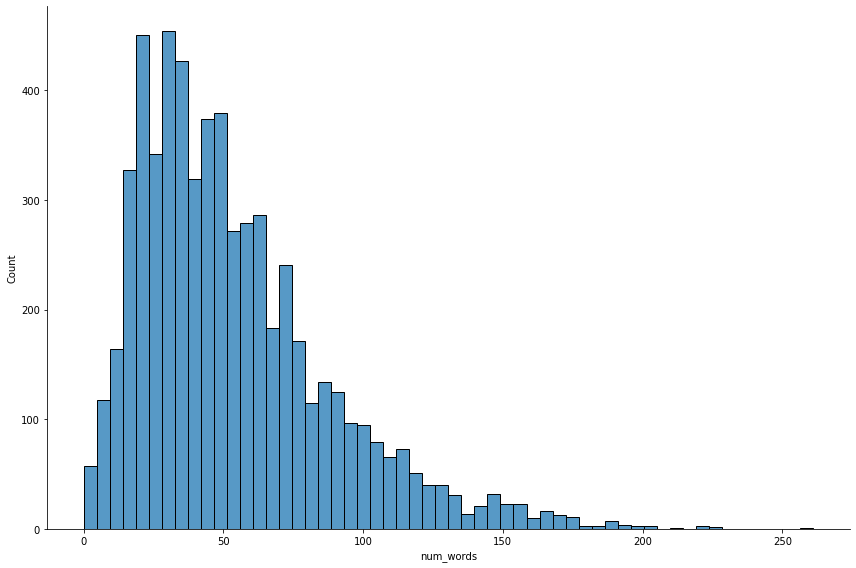

In [37]:
sns.displot(preprocessed_df.num_words,height=8,aspect=1.5)

In [38]:
max_len = 100

## Text Tokenization

In [39]:
tokenizer(text='So Dick , how about getting some coffee for tonight aaaaaaaaa kifech ?',
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

{'input_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[  101,  2061,  5980,  1010,  2129,  2055,  2893,  2070,  4157,
         2005,  3892, 13360, 11057, 11057, 11057, 11382,  7959,  2818,
         1029,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [40]:
X_train = tokenizer(text=train_data.text.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.text.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

## Defining the model architecture

In [41]:
input_ids = Input(shape=(max_len,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(max_len,),name='attention_mask',dtype=tf.int32)

In [42]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0: final hidden state, 1: pooling output
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=7,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True

## Compiling the model

In [43]:
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=Adam(learning_rate=5e-5,epsilon=1e-8,decay=0.01,clipnorm=1.0),
              metrics=CategoricalAccuracy('balanced_accuracy'))

## Encoding the emotion labels

In [52]:
train_data['Label'] = train_data.Sentiment.map(encoded_labels)
test_data['Label'] = test_data.Sentiment.map(encoded_labels)

In [44]:
train_data.head()

,text,label,dataset,license,num_words
3172,own four five different men one afternoon feel...,3,emotion,educational/research,55
897,ow feels terrific,2,emotion,educational/research,17
5489,think main reason feeling overwhelmed exhauste...,1,emotion,educational/research,58
2339,m feeling less confident acting skills,2,emotion,educational/research,38
3876,feel duty warn taking last slice two reasons p...,2,emotion,educational/research,104


In [45]:
test_data.head()

,text,label,dataset,license,num_words
2732,sir remember but chinese usually celebrate new...,6,daily_dialog,CC BY-NC-SA 4.0,66
4727,the people say he she owe explanation skewed p...,6,go_emotions,apache license 2.0,95
5435,feel insulted saying real bigger man u real co...,0,emotion,educational/research,53
1409,ow get im feeling really shaky legged,1,emotion,educational/research,37
5604,feel tat us world clever depending u born u bo...,2,emotion,educational/research,147


## Generating the model summary and plot

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]          

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


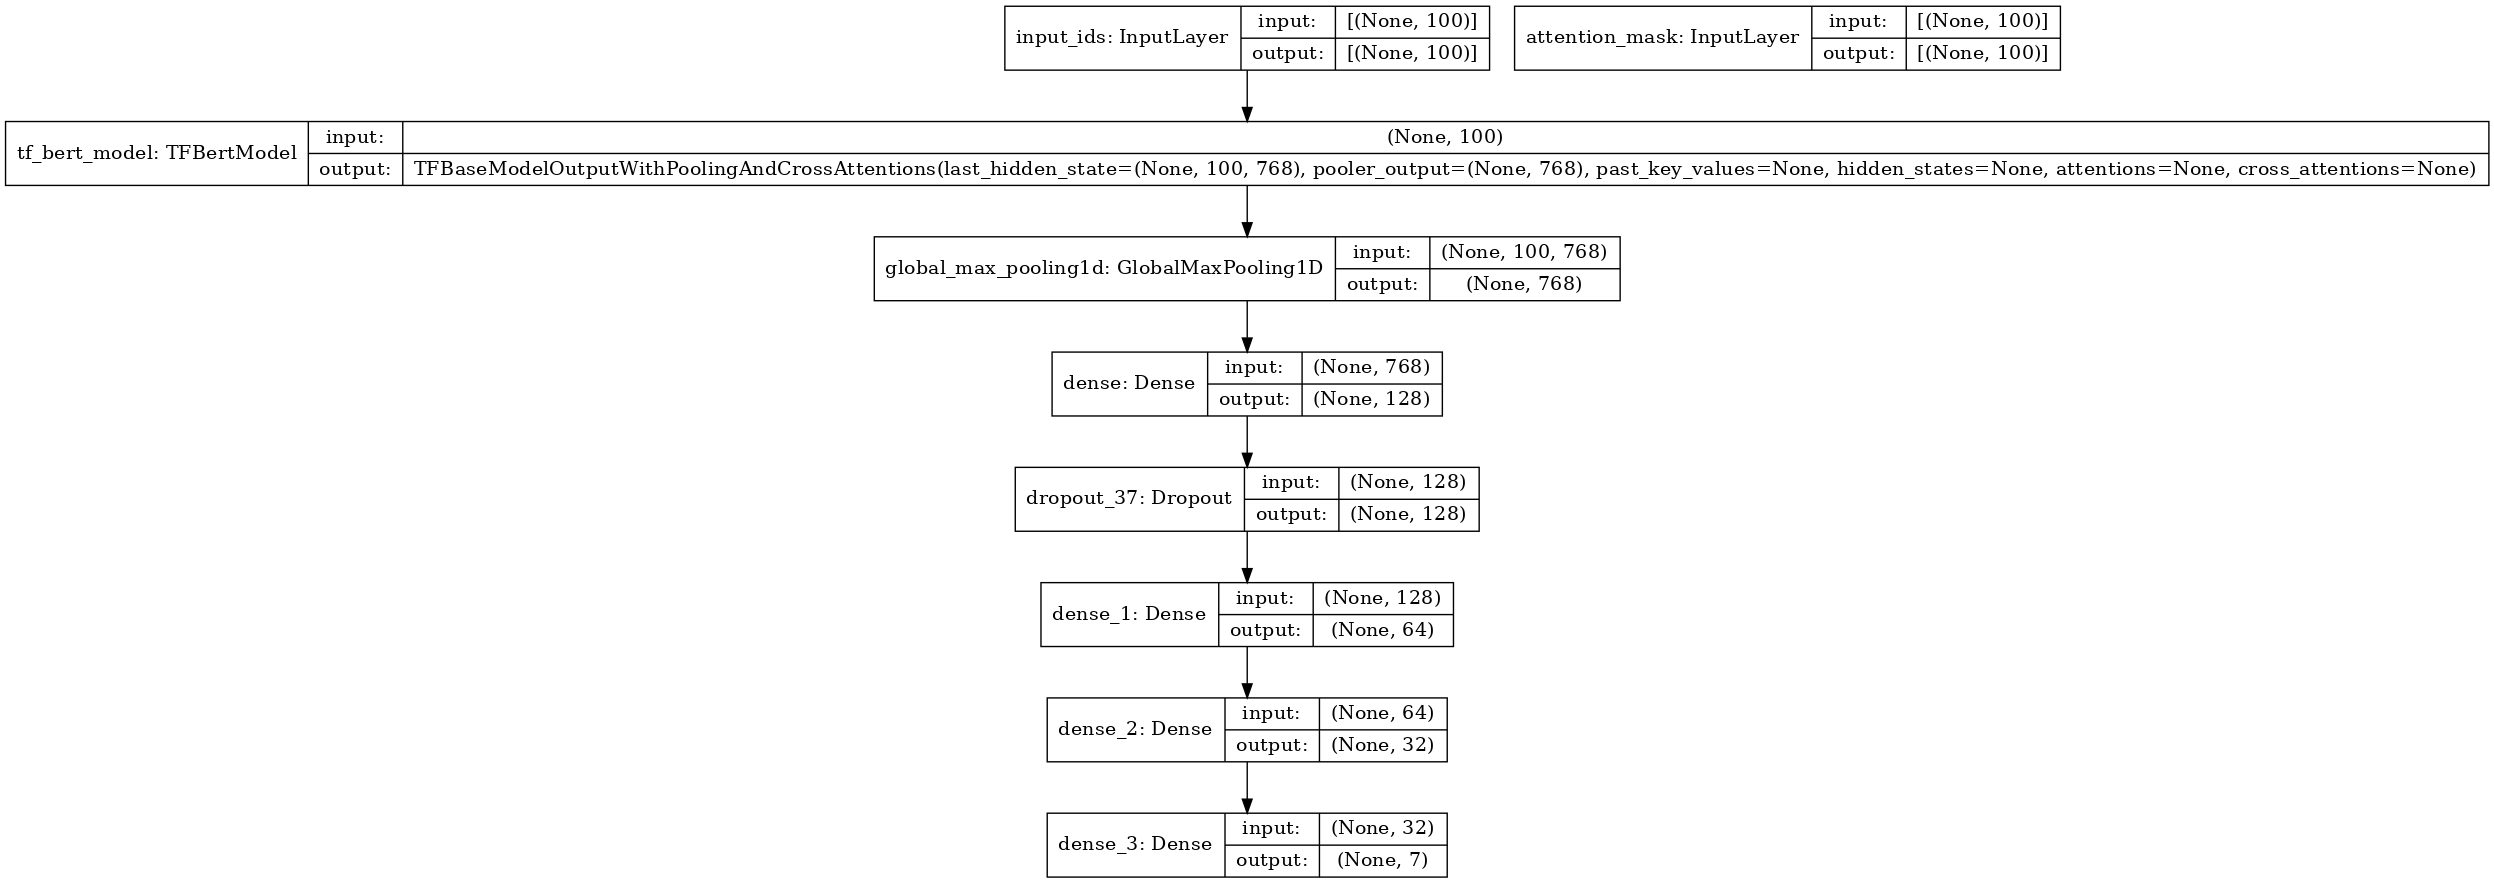

In [47]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

## Training and fine-tuning the pretrained BERT model 

In [48]:
X_train['input_ids'],X_train['attention_mask']

(<tf.Tensor: shape=(4188, 100), dtype=int32, numpy=
 array([[  101,  2219,  2176, ...,     0,     0,     0],
        [  101, 27593,  5683, ...,     0,     0,     0],
        [  101,  2228,  2364, ...,     0,     0,     0],
        ...,
        [  101, 23848,  3170, ...,     0,     0,     0],
        [  101,  3110, 24665, ...,     0,     0,     0],
        [  101,   102,     0, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(4188, 100), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0]], dtype=int32)>)

In [54]:
to_categorical(test_data.label)

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [55]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.label),
             epochs=10,
             batch_size=128,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.label))
             ) 

Epoch 1/10
131/131 [==============================] - 2090s 16s/step - loss: 1.2574 - balanced_accuracy: 0.5740 - val_loss: 0.9039 - val_balanced_accuracy: 0.6774
Epoch 2/10
131/131 [==============================] - 2053s 16s/step - loss: 0.7641 - balanced_accuracy: 0.7311 - val_loss: 0.6667 - val_balanced_accuracy: 0.7727
Epoch 3/10
131/131 [==============================] - 2042s 16s/step - loss: 0.5326 - balanced_accuracy: 0.8216 - val_loss: 0.5709 - val_balanced_accuracy: 0.8279
Epoch 4/10
131/131 [==============================] - 2034s 16s/step - loss: 0.4052 - balanced_accuracy: 0.8854 - val_loss: 0.5409 - val_balanced_accuracy: 0.8490
Epoch 5/10
131/131 [==============================] - 2040s 16s/step - loss: 0.3184 - balanced_accuracy: 0.9186 - val_loss: 0.5197 - val_balanced_accuracy: 0.8602
Epoch 6/10
131/131 [==============================] - 2032s 16s/step - loss: 0.2373 - balanced_accuracy: 0.9413 - val_loss: 0.5300 - val_balanced_accuracy: 0.8529
Epoch 7/10
131/131 [==

## Analyzing model performance

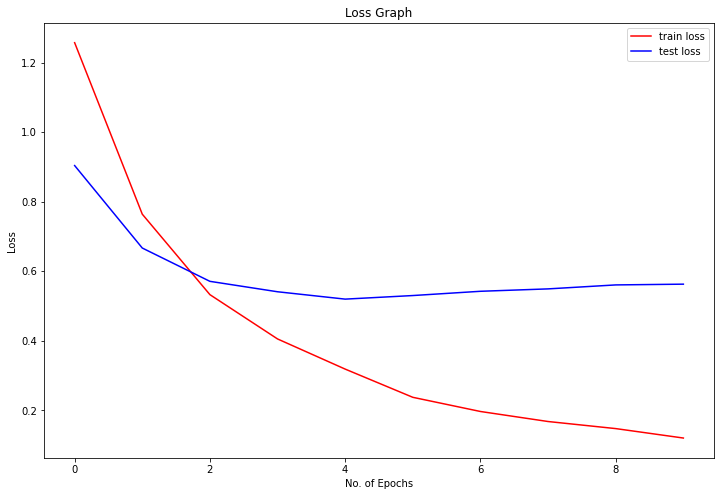

In [56]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

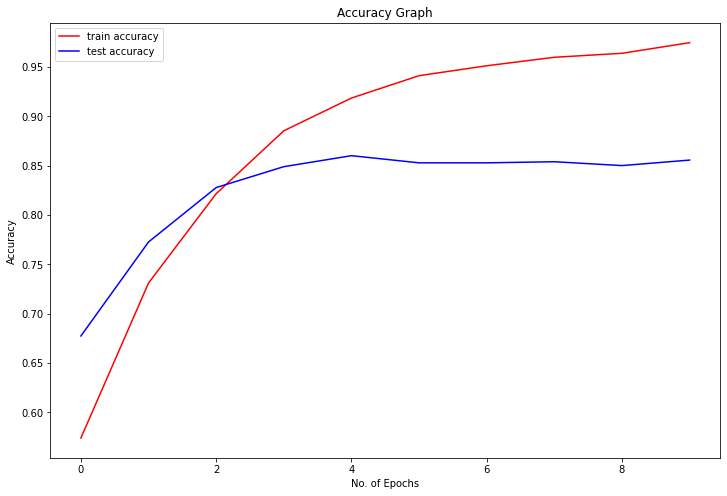

In [59]:
plt.figure(figsize=(12,8))
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [60]:
model.save("emotion_detector.h5")

## Evaluating the model on the test dataset

In [63]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

19/19 [==============================] - 2s 95ms/step - loss: 0.4433 - balanced_accuracy: 0.8850
Test Categorical Cross-Entropy Loss: 0.44329503178596497
Test Categorical Accuracy: 0.8849999904632568


In [64]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88        87
           1       0.94      0.79      0.86        73
           2       0.92      0.91      0.92       192
           3       0.81      0.64      0.72        53
           4       0.91      0.94      0.92       177
           5       0.68      0.94      0.79        18

    accuracy                           0.89       600
   macro avg       0.85      0.86      0.85       600
weighted avg       0.89      0.89      0.88       600



The result is quite promising as we've obtained an excellent f1-score of almost 80% for all the 6 emotion classes.

In [7]:
os.path.exists('/kaggle/working/emotion_detector.h5')

True

In [18]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Define the path to your saved model
model_path = "/kaggle/working/emotion_detector.h5"

# Load the model with the necessary custom objects
model = tf.keras.models.load_model(
    model_path,
    custom_objects={"TFBertModel": TFBertModel}
)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model_1[0][0]        

In [ ]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer.save_pretrained('/kaggle/working/tokenizer')

In [34]:
map_labels = {
    6:"neutral",
    2:'Joy',
    0:"Anger",
    5:"Surprise",
    1:"fear",
    3:"Love",
    4:"sadness",
}

In [47]:
max_len = 100
text = 'Now, theres two reasons.'
def predict(model,tokenizer,text,max_len=100):
    inputs = tokenizer(text,max_length=max_len,padding='max_length',truncation=True,return_tensors='tf',return_token_type_ids=False,
                       return_attention_mask=True,
                       verbose=True)
    preds = model.predict([inputs["input_ids"],inputs["attention_mask"]])
    predicted_classes = tf.argmax(preds, axis=1)
    print(map_labels[predicted_classes[0].numpy()])
predict(model,tokenizer,text)

neutral
